In [7]:
from lib.helpers import np_exclude
from lib import algos, helpers, envs
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle

In [2]:
np.random.seed(42)
env = envs.ChainWithCycles(5,4)

In [8]:
gamma_range = np.linspace(0, 1.0, 51)[:-1]
zeta_range = np.linspace(0, 1.0, 51)
param_grid = list(itertools.product(gamma_range, zeta_range))

In [4]:
Qs_by_param = {}
iterations = {}
converged = {}
deltas = {}
for gamma, zeta in tqdm(param_grid):
    V_STAR = algos.value_iter(env, gamma)
    Q_STAR = algos.V2Q(env, V_STAR, gamma)
    V, metadata = algos.value_iter_near_greedy(env, gamma, zeta=zeta, V_star=V_STAR, max_iter=1000)
    Q = algos.V2Q(env, V, gamma)
    policies, delta = metadata['policies'], metadata['delta']
    Qs_by_param[gamma, zeta] = Q_STAR, Q, zeta
    iterations[gamma, zeta] = len(policies) - 1
    converged[gamma, zeta] = (policies[-1] == policies[-2]).all() #(delta < 1e-10)
    deltas[gamma, zeta] = delta

100%|██████████| 2550/2550 [05:18<00:00,  8.02it/s]


In [ ]:
# TDE at end of learning
policy_tdes = deltas
df_tde = pd.DataFrame()
df_tde.index.name = 'zeta'
df_tde.columns.name = 'gamma'
for zeta in zeta_range:
    for gamma in gamma_range:
        df_tde.loc[zeta,gamma] = policy_tdes[gamma,zeta]
    df_tde.loc[zeta, 1.0] = np.nan

# Average policy size
policy_sizes = {}
for gamma, zeta in param_grid:
    Q_star, Q, zeta_ = Qs_by_param[gamma, zeta]
    assert zeta == zeta_
    V_star = Q_star.max(axis=1, keepdims=True)
    pi = (np_exclude(Q, env.S_terminal) >= (1-zeta) * np_exclude(V_star, env.S_terminal)).astype(int)
    policy_size = pi.sum(axis=1).mean()
    policy_sizes[gamma, zeta] = policy_size

df_policy_sizes = pd.Series(policy_sizes).unstack().T
df_policy_sizes.index.name = 'zeta'
df_policy_sizes.columns.name = 'gamma'
df_policy_sizes.loc[:, 1.0] = np.nan

# Converged?
df_converged = pd.Series(converged).unstack().T

In [ ]:
df_tde.to_csv('output_converge/cycchain5_tde.csv')
df_policy_sizes.to_csv('output_converge/cycchain5_psize.csv')
df_converged.to_csv('output_converge/cycchain5_converged.csv')
joblib.dump({'policy_sizes': policy_sizes, 'policy_tdes': policy_tdes, 'converged': converged}, 'output_converge/cycchain5.joblib')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [27]:
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif'

In [21]:
df_policy_sizes = pd.read_csv('output_converge/cycchain5_psize.csv')
f = joblib.load('output_converge/cycchain5.joblib')
policy_sizes = f['policy_sizes']
policy_tdes = f['policy_tdes']
converged = f['converged']

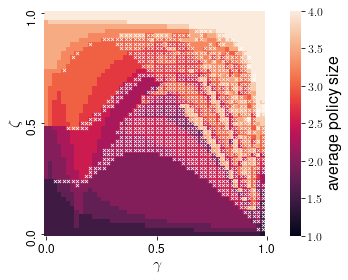

In [45]:
coords_policy = []
coords_i = []
for i, (gamma, zeta) in enumerate(param_grid):
    try:
        psize = policy_sizes[gamma, zeta]
        ptde = policy_tdes[gamma, zeta]
        pconv = converged[gamma, zeta]
    except:
        psize = policy_sizes[np.around(gamma,2), np.round(zeta,2)]
        ptde = policy_tdes[np.around(gamma,2), np.round(zeta,2)]
        pconv = converged[np.around(gamma,2), np.round(zeta,2)]
    
    if not pconv:
        coords_policy.append((gamma, zeta))
        coords_i.append((i//51+0.5, i%51+0.5))

# fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(
    df_policy_sizes, square=True, #ax=ax,
    cbar_kws=dict(label='average policy size'),
    vmin=1, vmax=4,
    xticklabels=25, yticklabels=25,
)
ax.invert_yaxis()
ax.tick_params(labelsize='large')
cbar = ax.collections[0].colorbar.ax.tick_params(labelsize=12)
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('$\zeta$', fontsize=16)
plt.scatter(*zip(*coords_i), c='w', s=10, marker='x', linewidth=.75)
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.tight_layout()
plt.savefig('figures/converge_cycchain5.pdf', bbox_inches='tight')
plt.show()

In [6]:
for gamma, zeta in {(0.0, 0.0)}:
    Q_star, Q, zeta_ = Qs_by_param[gamma, zeta]
    assert zeta == zeta_
    V_star = Q_star.max(axis=1, keepdims=True)
    pi = (np_exclude(Q, env.S_terminal) >= (1-zeta) * np_exclude(V_star, env.S_terminal)).astype(int)
    policy_size = pi.sum(axis=1).mean()
    policy_sizes[gamma, zeta] = policy_size


In [7]:
env.P

{0: {0: [(1.0, 0, 0.01, False)],
  1: [(1.0, 1, 0.04, False)],
  2: [(1.0, 0, 0.02, False)],
  3: [(1.0, 1, 0.0, False)]},
 1: {0: [(1.0, 0, 0.03, False)],
  1: [(1.0, 2, 0.01, False)],
  2: [(1.0, 0, 0.02, False)],
  3: [(1.0, 2, 0.0, False)]},
 2: {0: [(1.0, 1, 0.01, False)],
  1: [(1.0, 3, 0.0, False)],
  2: [(1.0, 1, 0.03, False)],
  3: [(1.0, 3, 0.04, False)]},
 3: {0: [(1.0, 2, 0.0, False)],
  1: [(1.0, 4, 1.01, True)],
  2: [(1.0, 2, 0.02, False)],
  3: [(1.0, 4, 1.03, True)]},
 4: {0: [(1.0, 4, 0.0, True)],
  1: [(1.0, 4, 0.0, True)],
  2: [(1.0, 4, 0.0, True)],
  3: [(1.0, 4, 0.0, True)]}}

In [8]:
pi

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [9]:
policy_size = pi.sum(axis=1).mean()

In [10]:
policy_size

1.0

In [10]:
df_converged

,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98
0.00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0.02,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0.04,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False
0.06,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
0.08,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False
0.10,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False
0.12,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,False,False,False
0.14,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,False,False,True
0.16,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,False,False,False
0.18,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,False,False,False,False,False


In [6]:
df_policy_sizes

gamma,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98
zeta,,,,,,,,,,,,,,,,,,,,,
0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
0.02,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,...,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.00
0.04,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.25,1.25,...,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.50,2.00,1.25
0.06,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.25,1.25,...,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.25
0.08,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.25,1.25,...,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.50
0.10,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.25,1.25,...,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,2.00,1.50
0.12,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.25,1.25,...,1.75,1.75,1.75,1.75,2.00,2.00,2.00,2.00,2.25,1.75
0.14,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.50,1.25,...,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.25,1.50
0.16,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.50,1.50,1.25,...,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.25,2.50,1.75


In [8]:
df_tde

gamma,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
zeta,,,,,,,,,,,,,,,,,,,,,
0.00,0.0,1.387779e-17,1.387779e-17,1.179612e-15,1.873501e-16,3.400058e-15,5.342948e-16,5.537237e-15,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.204393e-11,NaN
0.02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,1.060831e-11,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.145460e-03,NaN
0.04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.078400e-02,7.549354e-03,NaN
0.06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.030695e-03,NaN
0.08,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.918400e-02,5.315826e-03,NaN
0.10,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.918400e-02,6.757658e-03,NaN
0.12,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.756400e-02,7.918400e-02,8.069950e-03,NaN
0.14,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,9.276607e-12,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.175640e-01,7.918400e-02,4.568415e-04,NaN
0.16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.469447e-17,6.938894e-18,0.000000e+00,9.276607e-12,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351360e-01,1.175640e-01,7.601664e-02,1.091559e-02,NaN
